In [1]:
#################################################
#Spectral analysis and Change Detection Practice#
#Maintainer: Christopher Chan                   #
#Date: 2024-06-17                               #
#Version: 0.1.2                                 #
#################################################

import os, sys
import pysal
import pygis
import pathlib
import earthpy
import pyproj
import rioxarray

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import seaborn as sns
import earthpy as et
import earthpy.plot as ep
import matplotlib.pyplot as plt

from rasterio.plot import show
from shapely.geometry import shape
%matplotlib inline

data_path = pathlib.Path("../data")
raster_inter = pathlib.Path("../data/02_intermediate/raster/L2A_Eliburn_2024-06-05 23_17_20.602139")

## Masking and preprocessing

(92, 136)
(92, 136)
16
(92, 136)


/Users/christopherchan/mambaforge/envs/ds_geospatial/lib/python3.10/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


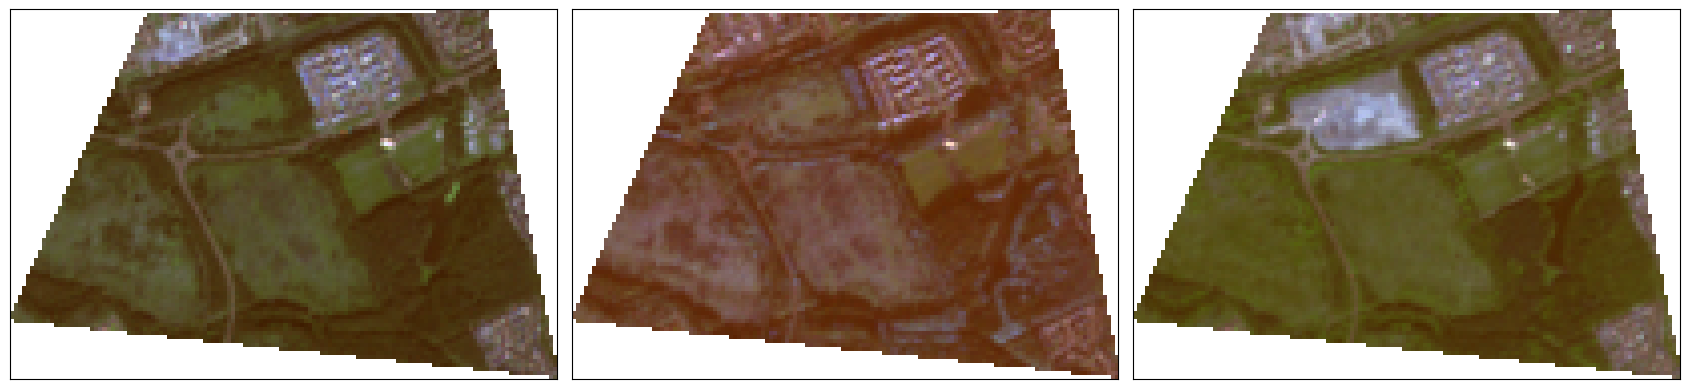

In [2]:
with rio.open(f"{raster_inter}/L2A_Eliburn_2024-05-18.tif", "r+", driver = "GTiff", crs = "EPSG:27700") as src:
    transform = src.transform
    crs = src.crs
    b2, b3, b4, b8 = src.read(2).astype("float32"), src.read(3).astype("float32"), src.read(4).astype("float32"), src.read(8).astype("float32")
    b8a, b11 = src.read(9).astype("float32"), src.read(12).astype("float32")
    print(src.shape)
    rgb_20240518 = np.stack((b2, b3, b4))
    # Built (RED-BLUE), NDBI(SWIR-NIR)
    builtRB_20240518 = (b4-b2)/(b4+b2)
    ndbi_20240518 = (b11-b8)/(b11+b8)
    ndwi_20240518 = (b3-b8)/(b3+b8)
    ndvi_20240518 = (b8-b4)/(b8+b4)
    
with rio.open(f"{raster_inter}/L2A_Eliburn_2023-11-05.tif", "r+", driver = "GTiff", crs = "EPSG:27700") as src:
    b2, b3, b4, b8 = src.read(2).astype("float32"), src.read(3).astype("float32"), src.read(4).astype("float32"), src.read(8).astype("float32")
    b8a, b11 = src.read(9).astype("float32"), src.read(12).astype("float32")
    print(src.shape)
    rgb_20231105 = np.stack((b2, b3, b4))
    builtRB_20231105 = (b4-b2)/(b4+b2)
    ndbi_20231105 = (b11-b8)/(b11+b8)
    ndwi_20231105 = (b3-b8)/(b3+b8)
    ndvi_20231105 = (b8-b4)/(b8+b4)

with rio.open(f"{raster_inter}/L2A_Eliburn_2023-09-04.tif", "r+", driver = "GTiff", crs = "EPSG:27700") as src:
    b2, b3, b4, b8 = src.read(2).astype("float32"), src.read(3).astype("float32"), src.read(4).astype("float32"), src.read(8).astype("float32")
    b8a, b11 = src.read(9).astype("float32"), src.read(12).astype("float32")
    print(src.count)
    print(src.shape)
    rgb_20230904 = np.stack((b2, b3, b4))
    builtRB_20230904 = (b4-b2)/(b4+b2)
    ndbi_20230904 = (b11-b8)/(b11+b8)
    ndwi_20230904 = (b3-b8)/(b3+b8)
    ndvi_20230904 = (b8-b4)/(b8+b4)

fig, ax = plt.subplots(1, 3, figsize = (17, 10))
ep.plot_rgb(rgb_20230904, ax=ax[0])
ep.plot_rgb(rgb_20231105, ax=ax[1])
ep.plot_rgb(rgb_20240518, ax=ax[2])

plt.tight_layout()
plt.show()


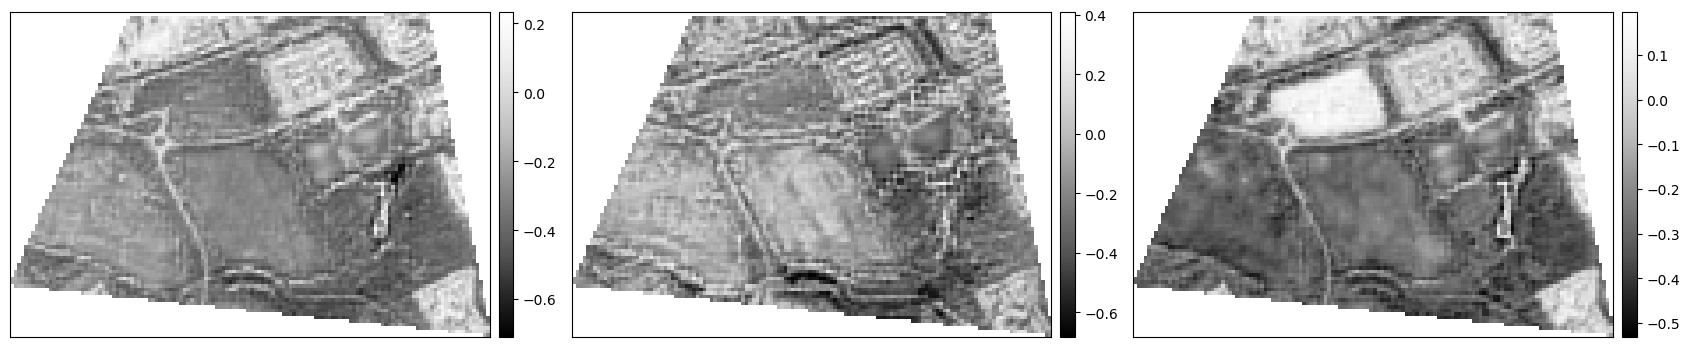

In [3]:
fig, ax = plt.subplots(1, 3, figsize = (17, 10))
ep.plot_bands(ndbi_20230904, ax=ax[0])
ep.plot_bands(ndbi_20231105, ax=ax[1])
ep.plot_bands(ndbi_20240518, ax=ax[2])

plt.tight_layout()
plt.show()

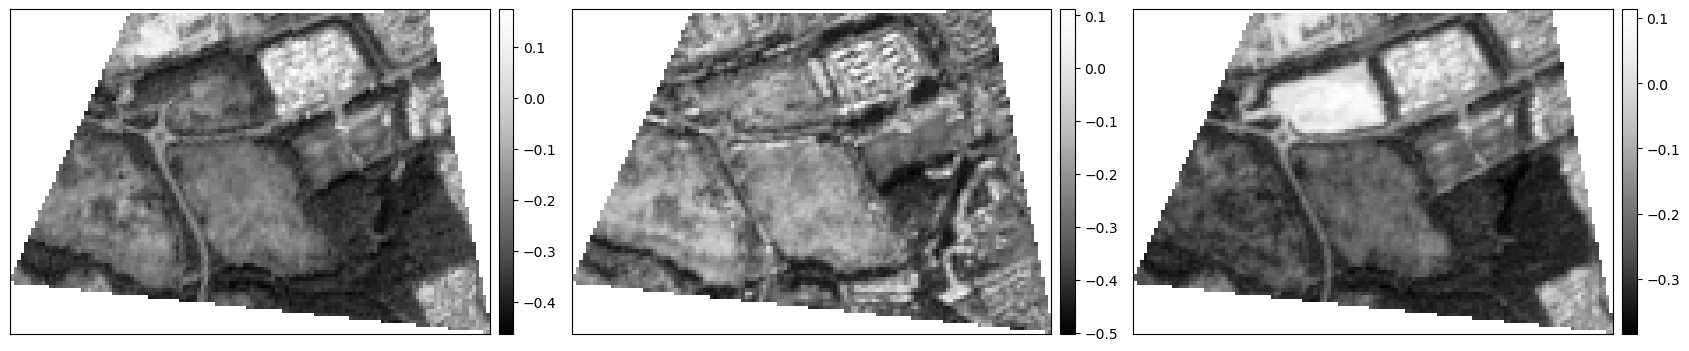

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (17, 10))
ep.plot_bands(builtRB_20230904, ax=ax[0])
ep.plot_bands(builtRB_20231105, ax=ax[1])
ep.plot_bands(builtRB_20240518, ax=ax[2])

plt.tight_layout()
plt.show()

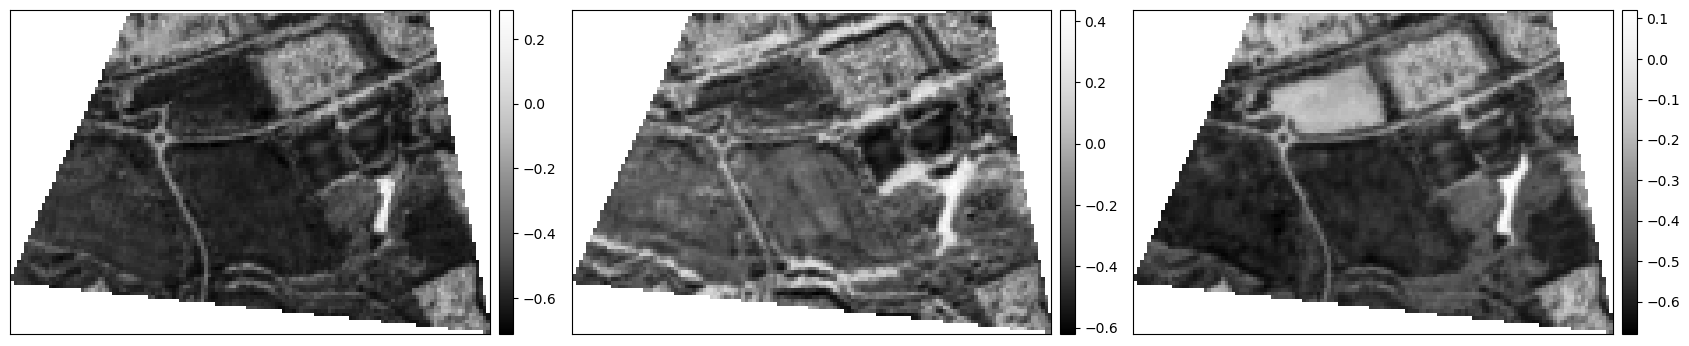

In [5]:
#NDWI
fig, ax = plt.subplots(1, 3, figsize = (17, 10))
ep.plot_bands(ndwi_20230904, ax=ax[0])
ep.plot_bands(ndwi_20231105, ax=ax[1])
ep.plot_bands(ndwi_20240518, ax=ax[2])

plt.tight_layout()
plt.show()

In [6]:
# Writing raster moodule
def write_raster(out_path, data, band_count):

    with rio.open(out_path, "w",
         height=data.shape[0], width=data.shape[1],
         count=band_count, dtype=data.dtype,
         crs=src.crs, transform=src.transform,
         driver="GTiff") as dst:
        
        dst.write(data, 1)

ndvi_list = [ndvi_20230904, ndvi_20231105, ndvi_20240518]

def get_var_name(var):                                                                                   
    for name in globals():                                                                               
        if globals()[name] is var:                                                                       
            return name 

for i in ndvi_list:
    write_raster(f"{data_path}/02_intermediate/raster/{get_var_name(i)}.tif", i, band_count=1)

/Users/christopherchan/mambaforge/envs/ds_geospatial/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


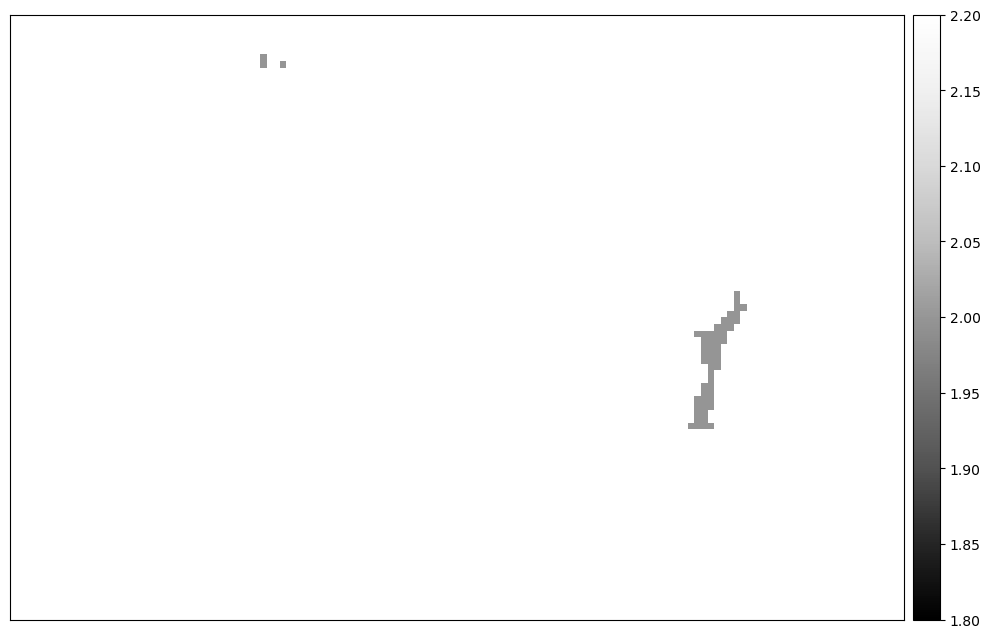

<Axes: >

In [7]:
water_20240518 = np.where(ndwi_20240518 > -0.1, 2, np.nan)

with rio.open(f"{data_path}/02_intermediate/raster/water_20240518.tif", "w", 
              height=water_20240518.shape[0], width=water_20240518.shape[1],
              count=1, dtype=water_20240518.dtype,
              crs="EPSG:27700",
              driver="GTiff") as dest:
    dest.write(water_20240518, 1)

ep.plot_bands(water_20240518)

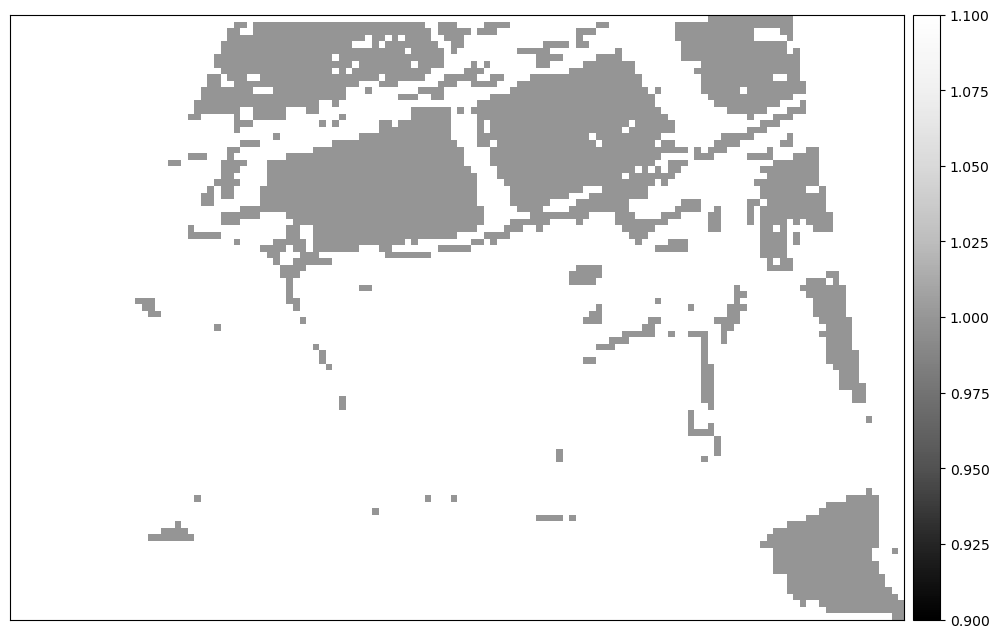

<Axes: >

In [8]:
# Replace urban areas with 1, else 0
built_20240518 = np.where(ndbi_20240518 > -0.15 ,1, np.nan)

with rio.open(f"{data_path}/02_intermediate/raster/built_20240518.tif", "w", 
              height=built_20240518.shape[0], width=built_20240518.shape[1],
              count=1, dtype=built_20240518.dtype,
              crs="EPSG:27700",
              driver="GTiff") as dest:
    dest.write(built_20240518, 1)

ep.plot_bands(built_20240518)

In [9]:
!gdal_polygonize.py ~/Proj/geospatial/data/02_intermediate/raster/built_20240518.tif -b 1 -f "GeoJSON" ~/Proj/geospatial/data/02_intermediate/vector/built_20240518.geojson built_20240518 DN

0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
# Polygonise water
water_shapes = list(rio.features.shapes(water_20240518.astype("float32"), mask=None, transform=transform, connectivity=4))
print(water_shapes)

DFwater_20240518 = pd.DataFrame(water_shapes, columns = ["geometry", "value"])
DFwater_20240518['geometry'] = DFwater_20240518['geometry'].apply(lambda x: shape(x))
GDFwater_20240518 = gpd.GeoDataFrame(DFwater_20240518, geometry='geometry', crs="EPSG:27700")

GDFwater_20240518.to_file(f"{data_path}/02_intermediate/vector/GDFwater_20240518.geojson", driver="GeoJSON")

# Polygonise building
built_shapes = list(rio.features.shapes(built_20240518.astype("float32"), mask=None, transform=transform, connectivity=4))
print(built_shapes)

DFbuilt_20240518 = pd.DataFrame(built_shapes, columns = ["geometry", "value"])
DFbuilt_20240518['geometry'] = DFbuilt_20240518['geometry'].apply(lambda x: shape(x))
GDFbuilt_20240518 = gpd.GeoDataFrame(DFbuilt_20240518, geometry='geometry', crs="EPSG:27700")

GDFbuilt_20240518.to_file(f"{data_path}/02_intermediate/vector/GDFbuilt_20240518.geojson", driver="GeoJSON")

features_20240518 = pd.concat([GDFbuilt_20240518, GDFwater_20240518], ignore_index=True)
features_20240518.to_file(f"{data_path}/02_intermediate/vector/GDFfeatures_20240518.geojson", driver="GeoJSON")

[({'type': 'Polygon', 'coordinates': [[(302440.0, 668320.0), (302440.0, 668300.0), (302450.0, 668300.0), (302450.0, 668320.0), (302440.0, 668320.0)]]}, 2.0), ({'type': 'Polygon', 'coordinates': [[(302470.0, 668310.0), (302470.0, 668300.0), (302480.0, 668300.0), (302480.0, 668310.0), (302470.0, 668310.0)]]}, 2.0), ({'type': 'Polygon', 'coordinates': [[(303160.0, 667960.0), (303160.0, 667930.0), (303150.0, 667930.0), (303150.0, 667920.0), (303140.0, 667920.0), (303140.0, 667910.0), (303130.0, 667910.0), (303130.0, 667900.0), (303100.0, 667900.0), (303100.0, 667890.0), (303110.0, 667890.0), (303110.0, 667850.0), (303120.0, 667850.0), (303120.0, 667820.0), (303110.0, 667820.0), (303110.0, 667800.0), (303100.0, 667800.0), (303100.0, 667760.0), (303090.0, 667760.0), (303090.0, 667750.0), (303130.0, 667750.0), (303130.0, 667760.0), (303120.0, 667760.0), (303120.0, 667780.0), (303130.0, 667780.0), (303130.0, 667840.0), (303140.0, 667840.0), (303140.0, 667880.0), (303150.0, 667880.0), (303150.0

In [11]:
features_20240518.explore("value", tiles="OpenStreetMap", legend=True)

                                              geometry  value
0    POLYGON ((302950.000 668370.000, 302950.000 66...    1.0
1    POLYGON ((302780.000 668370.000, 302780.000 66...    1.0
5    POLYGON ((302920.000 668360.000, 302920.000 66...    1.0
8    POLYGON ((302710.000 668370.000, 302710.000 66...    1.0
11   POLYGON ((302870.000 668340.000, 302870.000 66...    1.0
..                                                 ...    ...
102  POLYGON ((303400.000 667570.000, 303400.000 66...    1.0
103  POLYGON ((303360.000 667660.000, 303360.000 66...    1.0
105  POLYGON ((302440.000 668320.000, 302440.000 66...    2.0
106  POLYGON ((302470.000 668310.000, 302470.000 66...    2.0
107  POLYGON ((303160.000 667960.000, 303160.000 66...    2.0

[71 rows x 2 columns]


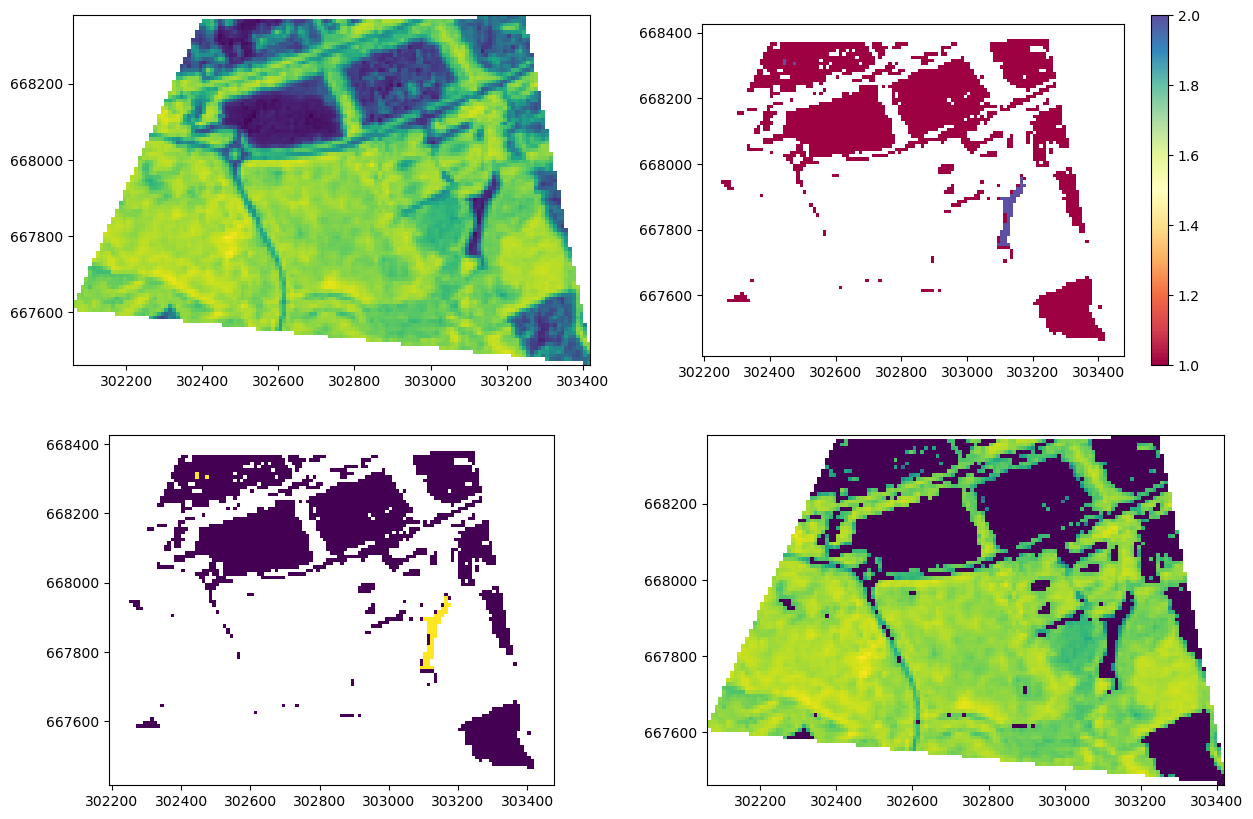

In [12]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10), sharey=False, sharex=False)

with rio.open(f"{data_path}/02_intermediate/raster/ndvi_20240518.tif", "r+", driver="GTiff", crs="EPSG:27700") as src:
    assert src.crs == features_20240518.crs
    ndvi_raster = src.read(1)
    rio.plot.show(ndvi_raster, transform=src.transform, ax=ax[0, 0])
    features_20240518.plot(column = "value", ax=ax[0, 1], legend=True, cmap="Spectral")
    filtered_features = features_20240518[features_20240518["value"].notnull()]
    filtered_features.plot(column = "value", ax=ax[1, 0])
    print(filtered_features)
    ndvi_mask, ndvi_transform = rio.mask.mask(src, filtered_features.geometry, crop=False, invert=True)

    rio.plot.show(ndvi_mask, transform=src.transform, ax=ax[1, 1])

#with rioxarray.open_rasterio(f"{data_path}/02_intermediate/raster/ndvi_20240518.tif") as src:
#    print(type(src))
#    ndvi_mask = src.rio.clip(features_20240518.geometry.values, features_20240518.crs, invert=True)
#    ndvi_mask.plot(ax=ax[1,0])

In [13]:
def crop_vegetation(ndvi_path:pathlib.Path, features):
    img_name = ndvi_path.name
    print(img_name)

    with rio.open(ndvi_path, "r+", driver="GTiff", crs="EPSG:27700") as src:
        assert src.crs == features_20240518.crs
        ndvi_raster = src.read(1)
        filtered_features = features_20240518[features_20240518["value"].notnull()]
        ndvi_mask, ndvi_transform = rio.mask.mask(src, filtered_features.geometry, crop=False, invert=True)

    with rio.open(f"{data_path}/03_primary/raster/feature20240518_{img_name}", "w",
             height=src.shape[0], width=src.shape[1],
             count=1, dtype="float32",
             crs=src.crs, transform=src.transform,
             driver="GTiff") as dst:

             dst.write(ndvi_mask)
       
crop_vegetation(pathlib.Path(f"{data_path}/02_intermediate/raster/ndvi_20230904.tif"), features_20240518)
crop_vegetation(pathlib.Path(f"{data_path}/02_intermediate/raster/ndvi_20231105.tif"), features_20240518)
crop_vegetation(pathlib.Path(f"{data_path}/02_intermediate/raster/ndvi_20240518.tif"), features_20240518)

ndvi_20230904.tif
ndvi_20231105.tif
ndvi_20240518.tif


feature20240518_ndvi_20240518
feature20240518_ndvi_20230904
feature20240518_ndvi_20231105


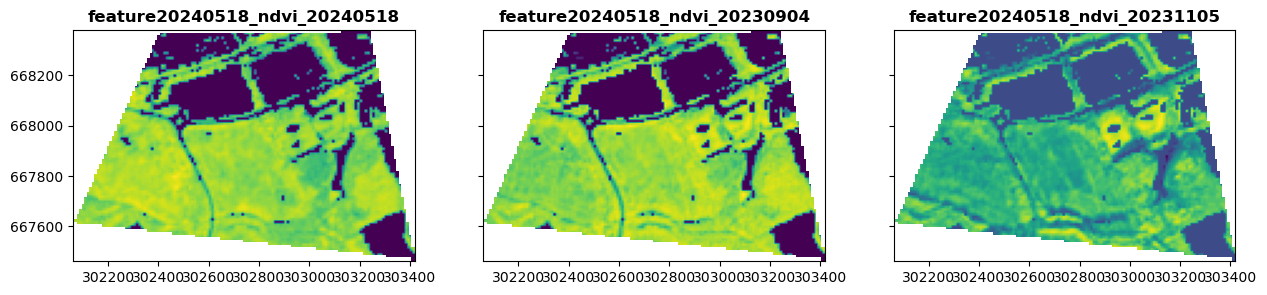

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (15, 10), sharey=True)

i = 0
ndvi_cropList = {}

for root, dirs, files in os.walk(pathlib.Path(f"{data_path}/03_primary/raster")):
    for f in files:
        if f.endswith(".tif") and f.startswith("feature"):
            file_name = f.split(".")[0]
            print(file_name)
            if i < len(ax):
                with rio.open(root+"/"+f, "r+", driver="GTiff", crs="EPSG:27700") as src:
                    transform = src.transform
                    ndvi_raster = src.read(1)
                    ndvi_cropList[file_name] = ndvi_raster
                    rio.plot.show(ndvi_raster, transform=transform, ax=ax[i], title=file_name)
                i += 1

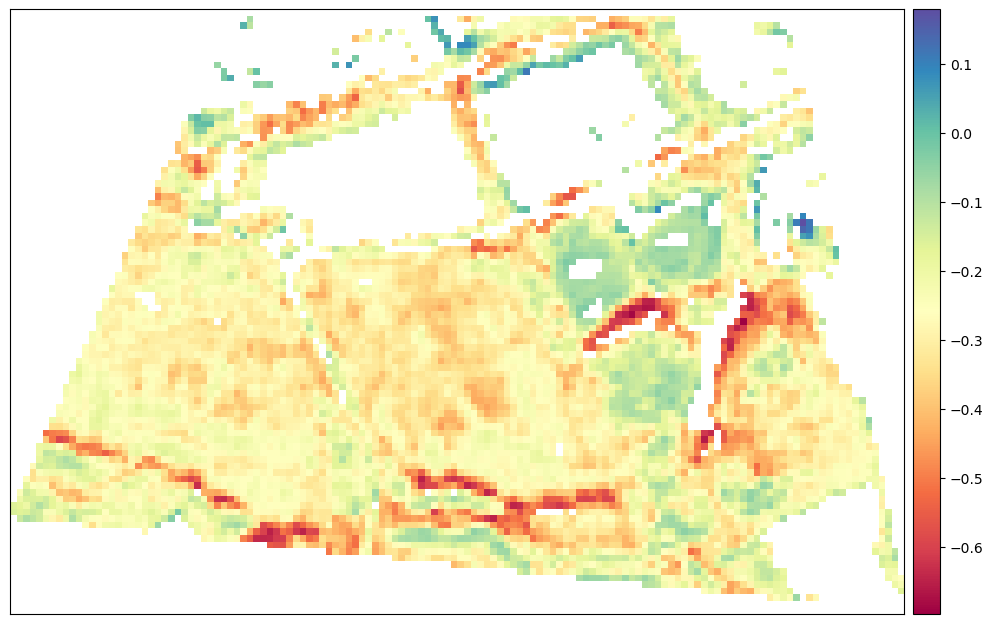

In [20]:
dNDVI_20231105_20230904 = ndvi_cropList.get("feature20240518_ndvi_20231105") - ndvi_cropList.get("feature20240518_ndvi_20230904")
dNDVI_20231105_20230904 = np.where(dNDVI_20231105_20230904 == 0, np.nan, dNDVI_20231105_20230904)

ep.plot_bands(dNDVI_20231105_20230904, cmap="Spectral")

with rio.open(f"{data_path}/03_primary/raster/dNDVI_20231105_20230904.tif", "w", 
              height=dNDVI_20231105_20230904.shape[0], width=dNDVI_20231105_20230904.shape[1],
              count=1, dtype=dNDVI_20231105_20230904.dtype, 
              crs="EPSG:27700", transform = src.transform,
              driver="GTiff") as dest:
    dest.write(dNDVI_20231105_20230904, 1)